In [11]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import PIL.Image
from collections import deque
from pyvirtualdisplay import Display

In [12]:
# Set up a virtual display to render the Lunar Lander environment.
Display(visible=0, size=(840, 480)).start();
env = gym.make('LunarLander-v2', render_mode="rgb_array")


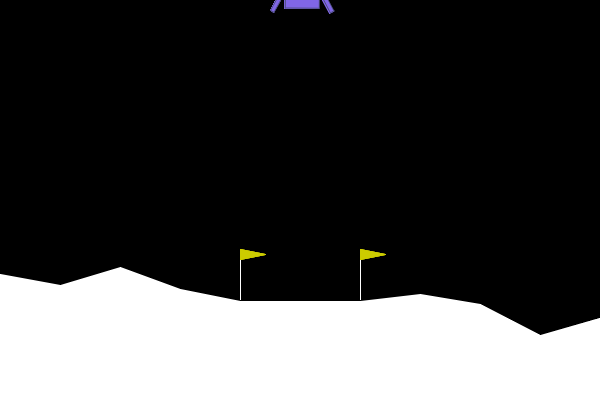

In [13]:
env.reset()
PIL.Image.fromarray(env.render())

In [14]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)
# Reset the environment and get the initial state.
initial_state = env.reset()
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, truncated, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Info:", info)
import torch
import torch.nn as nn
import torch.optim as optim
class DQN(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.out(x)
        return x
# Hyperparameters
# Hyperparameters
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 500
TARGET_UPDATE = 10
BATCH_SIZE = 64
LR = 0.001
MEMORY_SIZE = 10000
NUM_STEPS_FOR_UPDATE = 5

# Epsilon decay function
def get_new_eps(epsilon):
    return max(EPS_END, epsilon * 0.995)

# Memory buffer
memory_buffer = deque(maxlen=MEMORY_SIZE)

q_network = DQN(state_size[0], num_actions)
target_q_network = DQN(state_size[0], num_actions)

target_q_network.load_state_dict(q_network.state_dict())
optimizer = optim.AdamW(q_network.parameters(), lr=LR)

# Epsilon greedy approach to take action
def select_action(state, steps_done):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1 * steps_done/ EPS_DECAY)
    if np.random.rand() < eps_threshold:
        return torch.tensor(np.array([np.random.randint(0, num_actions)]).reshape(1, 1), dtype=torch.long)
    with torch.no_grad():
        return q_network(state).max(1)[1].view(1, 1)

# model optmization strategy
def optimize_model(replay_memory):
    if len(replay_memory) < BATCH_SIZE:
        return
    batch = random.sample(replay_memory, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.cat(states)
    actions = torch.cat(actions)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.cat(next_states)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

    Q_values = q_network(states).gather(1, actions)
    next_Q_values = target_q_network(next_states).max(1)[0].unsqueeze(1)
    target = rewards + (1 - dones) * GAMMA * next_Q_values

    criterion = nn.MSELoss()
    loss = criterion(Q_values, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epsilon = EPS_START
NUM_EPISODES = 2000
MAX_ITERATIONS = 1000
NUM_P_AV = 100 

episode_rewards = []

for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    state = torch.tensor([state], dtype=torch.float32)
    total_reward = 0
    steps_done = 0

    for _ in range(MAX_ITERATIONS):
        # Select action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = torch.tensor([[np.random.randint(num_actions)]], dtype=torch.long)
        else:
            with torch.no_grad():
                action = q_network(state).max(1)[1].view(1, 1)

        next_state, reward, done, _, _= env.step(action.item())
        next_state = torch.tensor([next_state], dtype=torch.float32)

        # Store experience in memory buffer
        memory_buffer.append((state, action, reward, next_state, done))

        # Update the network every NUM_STEPS_FOR_UPDATE time steps
        if steps_done % NUM_STEPS_FOR_UPDATE == 0 and len(memory_buffer) >= BATCH_SIZE:
            experiences = random.sample(memory_buffer, BATCH_SIZE)
            optimize_model(experiences)

        state = next_state
        total_reward += reward
        steps_done += 1

        if done:
            break

    # Update epsilon
    epsilon = get_new_eps(epsilon)

    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_q_network.load_state_dict(q_network.state_dict())

    episode_rewards.append(total_reward)
    av_latest_points = np.mean(episode_rewards[-NUM_P_AV:])
    print(f"\rEpisode {episode+1} | Total point average of the last {NUM_P_AV} episodes: {av_latest_points:.2f}", end="")

    if (episode+1) % NUM_P_AV == 0:
        print(f"\rEpisode {episode+1} | Total point average of the last {NUM_P_AV} episodes: {av_latest_points:.2f}")

    # If the total reward for the episode exceeds 200, stop the training and save the weights.
    if av_latest_points > 200:
        print(f"\n\nEnvironment solved in {episode+1} episodes with total reward {total_reward}!")
        torch.save(q_network.state_dict(), 'final_weights.pth')
        break

env.close()

State Shape: (8,)
Number of actions: 4
Initial State: (array([0.007, 1.405, 0.731, -0.257, -0.008, -0.166, 0.000, 0.000],
      dtype=float32), {})
Action: 0
Next State: [0.014 1.399 0.730 -0.283 -0.017 -0.164 0.000 0.000]
Reward Received: -0.9844890838578806
Episode Terminated: False
Info: {}
Episode 2 | Total point average of the last 100 episodes: -251.71

/Users/arindams_mac_m2_pro/opt/anaconda3/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/arindams_mac_m2_pro/opt/anaconda3/envs/py310/lib/python3.10/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Episode 100 | Total point average of the last 100 episodes: -165.40
Episode 200 | Total point average of the last 100 episodes: -68.807
Episode 300 | Total point average of the last 100 episodes: -24.07
Episode 400 | Total point average of the last 100 episodes: 28.779
Episode 500 | Total point average of the last 100 episodes: 78.58
Episode 600 | Total point average of the last 100 episodes: 63.61
Episode 700 | Total point average of the last 100 episodes: 111.00
Episode 800 | Total point average of the last 100 episodes: 159.97
Episode 900 | Total point average of the last 100 episodes: 25.266
Episode 1000 | Total point average of the last 100 episodes: 163.02
Episode 1100 | Total point average of the last 100 episodes: 173.69
Episode 1200 | Total point average of the last 100 episodes: 161.00
Episode 1290 | Total point average of the last 100 episodes: 200.15

Environment solved in 1290 episodes with total reward -5.823218000669525!


In [55]:
import imageio
import base64
import IPython

def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)
        
        
def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state, _ = env.reset()
        frame = env.render()
        video.append_data(frame)
        while not done:    
            state = torch.tensor([state], dtype=torch.float32)
            with torch.no_grad():
                action = q_network(state).max(1)[1].view(1, 1)
            state, _, done, _, _ = env.step(action.item())
            frame = env.render()
            video.append_data(frame)

env = gym.make('LunarLander-v2', render_mode="rgb_array")
create_video("./video/lunar_lander.mp4", env, q_network)

In [58]:
from IPython.display import Video
Video("./video/lunar_lander.mp4")